# Introduction to scvi-tools
In this introductory tutorial, we go through the different steps of an scvi-tools workflow.

While we focus on scVI in this tutorial, the API is consistent across all models.

In [1]:
# !pip install --quiet scvi-colab
# from scvi_colab import install
# install()

In [2]:
import scvi
import scanpy as sc
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(4, 4))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 0


## Loading and preparing data

Let us first load a subsampled version of the heart cell atlas dataset described in Litviňuková et al. (2020). scvi-tools has many "built-in" datasets as well as support for loading arbitrary `.csv`, `.loom`, and `.h5ad` (AnnData) files. Please see our tutorial on data loading for more examples.

* Litviňuková, M., Talavera-López, C., Maatz, H., Reichart, D., Worth, C. L., Lindberg, E. L., ... & Teichmann, S. A. (2020). Cells of the adult human heart. Nature, 588(7838), 466-472.

<div class="alert alert-info">
Important

All scvi-tools models require AnnData objects as input. 

</div>

Now we preprocess the data to remove, for example, genes that are very lowly expressed and other outliers. For these tasks we prefer the [Scanpy preprocessing module](https://scanpy.readthedocs.io/en/stable/api/index.html#module-scanpy.pp).

In [3]:
import os
import anndata

In [4]:
# !ls -ltrh ../../data/kmers_adata_*_k*.h5ad
# !rm ../../data/kmers_adata_*_k8.h5ad

In [5]:
ads = []
for f in os.listdir('../../data'):
    if f.endswith('_k11.h5ad'):
        p = os.path.join('../../data', f)
        print(p)
        ads.append(anndata.read_h5ad(p))
        
        if len(ads) == 10:
            break

../../data/kmers_adata_ALX1_k11.h5ad
../../data/kmers_adata_ALX4_k11.h5ad
../../data/kmers_adata_CTCF_k11.h5ad
../../data/kmers_adata_EGR1_k11.h5ad
../../data/kmers_adata_ELF2_k11.h5ad
../../data/kmers_adata_ELF3_k11.h5ad
../../data/kmers_adata_ELF4_k11.h5ad
../../data/kmers_adata_ELK1_k11.h5ad
../../data/kmers_adata_ELK3_k11.h5ad
../../data/kmers_adata_ETS1_k11.h5ad


In [6]:

adata = anndata.concat(ads, join='outer')

In [7]:
adata.shape

(232, 2097152)

In [8]:
# import anndata
# tf = 'ELK1'
# k = 10
# adata = anndata.read_h5ad('../../data/kmers_adata_%s_k%i.h5ad' % (tf, k))
# # map seqs as string
# map_seq2int = 0
# if map_seq2int:
#     adata.var_names = [mb.tl.string2bin(s) for s in list(adata.var_names)]
#     adata.write('../../data/kmers_adata_%s_k%i_int.h5ad' % (tf, k), compression='lzf')

In [9]:
# adata = ad1.concatenate(ad2, join='outer').concatenate(ad3, join='outer')

In [10]:
adata.shape

(232, 2097152)

In [11]:
adata = adata[:,adata.X.sum(axis=0) > 5000]

In [12]:
adata.shape

(232, 14897)

In [13]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

In [14]:
adata.shape

(232, 14897)

In [15]:
import scanpy as sc

In [16]:
adata

AnnData object with n_obs × n_vars = 232 × 14897
    obs: 'filename', 'library', 'batch', 'cycle', 'tf.name', 'accession', 'path'
    uns: 'log1p'
    layers: 'counts'

In [17]:
adata.shape

(232, 14897)

In [18]:
sc.pp.highly_variable_genes(
    adata, 
    n_top_genes=50000, 
    span =1,
    subset=True, 
    layer="counts", 
    flavor="seurat_v3",
    batch_key="accession",
)

In [19]:
print('highly_variable_gene_selection_done...')

highly_variable_gene_selection_done...


In [20]:
adata.shape

(232, 14897)

In [21]:
sc.pp.filter_genes(adata, min_counts=3)

In scRNA-seq analysis, it's popular to normalize the data. These values are not used by scvi-tools, but given their popularity in other tasks as well as for visualization, we store them in the anndata object separately (via the `.raw` attribute).

<div class="alert alert-info">

Important

Unless otherwise specified, scvi-tools models require the raw counts (not log library size normalized).

</div>

Finally, we perform feature selection, to reduce the number of features (genes in this case) used as input to the scvi-tools model. For best practices of how/when to perform feature selection, please refer to the model-specific tutorial. For scVI, we recommend anywhere from 1,000 to 10,000 HVGs, but it will be context-dependent.

Now it's time to run `setup_anndata()`, which alerts scvi-tools to the locations of various matrices inside the anndata. It's important to run this function with the correct arguments so scvi-tools is notified that your dataset has batches, annotations, etc. For example, if batches are registered with scvi-tools, the subsequent model will correct for batch effects. See the full documentation for details.

In this dataset, there is a "cell_source" categorical covariate, and within each "cell_source", multiple "donors", "gender" and "age_group". There are also two continuous covariates we'd like to correct for: "percent_mito" and "percent_ribo". These covariates can be registered using the `categorical_covariate_keys` argument. If you only have one categorical covariate, you can also use the `batch_key` argument instead.

In [22]:
adata.obs['accession']

ALX1_FL_1_KX_TACCAA40NTTA        PRJEB9797
ALX1_FL_1_KX_TCCTTG40NGGT        PRJEB9797
ALX1_FL_2_KX_TACCAA40NTTA        PRJEB9797
ALX1_FL_2_KX_TCCTTG40NGGT        PRJEB9797
ALX1_FL_3_KX_TACCAA40NTTA        PRJEB9797
                                   ...    
ETS1_TGTACC30NCAG_AI_6           PRJEB3289
ZeroCycle_ES0_TGTAAA20NGA_0     PRJEB14744
ZeroCycle_ES0_TGTACC30NCAG_0    PRJEB14744
ZeroCycle_TGTAAA20NGA_0_0        PRJEB3289
ZeroCycle_TGTACC30NCAG_0_0       PRJEB3289
Name: accession, Length: 232, dtype: object

In [19]:
adata.obs['batch'] = (adata.obs['accession'].astype(str) )# + ':' + adata.obs['library'].astype(str)).astype('category')
# adata.obs['batch'] = (adata.obs['accession'].astype(str)).astype('category')

In [20]:
adata.obs['batch'].value_counts()

PRJEB9797     136
PRJEB3289      58
PRJEB20112     28
PRJEB14744     10
Name: batch, dtype: int64

In [21]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["batch"], # , "donor"],
    # continuous_covariate_keys=["percent_mito", "percent_ribo"]
)

<div class="alert alert-warning">

Warning

If the adata is modified after running `setup_anndata`, please run `setup_anndata` again, before creating an instance of a model.

</div>

## Creating and training a model

While we highlight the scVI model here, the API is consistent across all scvi-tools models and is inspired by that of [scikit-learn](https://scikit-learn.org/stable/). For a full list of options, see the scvi [documentation](https://scvi-tools.org).

In [22]:
model = scvi.model.SCVI(adata)

We can see an overview of the model by printing it.

In [23]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

<div class="alert alert-info">
Important

All scvi-tools models run faster when using a GPU. By default, scvi-tools will use a GPU if one is found to be available. Please see the installation page for more information about installing scvi-tools when a GPU is available.

</div>

In [24]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
model.train(max_epochs=200)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:14<00:00, 13.69it/s, loss=4.87e+04, v_num=1]


### Saving and loading

Saving consists of saving the model neural network weights, as well as parameters used to initialize the model.

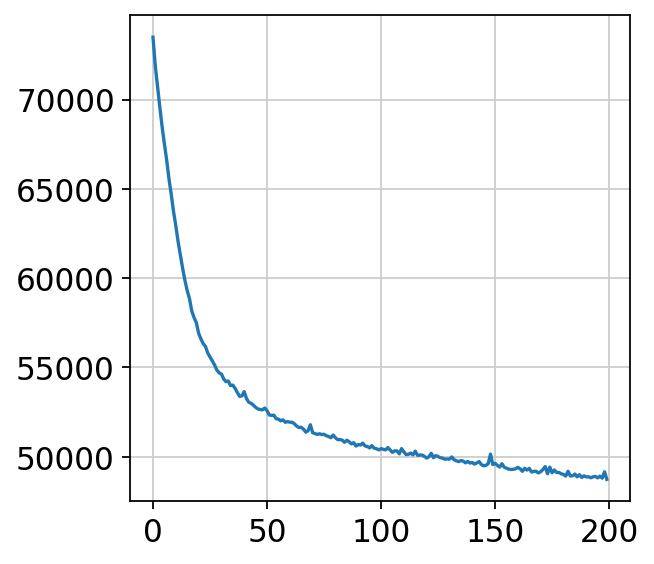

In [26]:
plt.plot(model.history['train_loss_epoch'])

In [31]:
# model.save("my_model/")

In [32]:
# model = scvi.model.SCVI.load("my_model/", adata=adata, use_gpu=True)

## Obtaining model outputs

In [27]:
latent = model.get_latent_representation()

It's often useful to store the outputs of scvi-tools back into the original anndata, as it permits interoperability with Scanpy.

In [28]:
adata.obsm["X_scVI"] = latent

The `model.get...()` functions default to using the anndata that was used to initialize the model. It's possible to also query a subset of the anndata, or even use a completely independent anndata object as long as the anndata is organized in an equivalent fashion.

In [29]:
adata_subset = adata[adata.obs['tf.name'] == "ELK1"]
latent_subset = model.get_latent_representation(adata_subset)

INFO     Received view of anndata, making copy.                                              
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


In [30]:
denoised = model.get_normalized_expression(adata_subset, library_size=1e4)
denoised.iloc[:5, :5]

,AAAAAACCGGA,AAAAACAGGAA,AAAAACCAGGA,AAAAACCGGAA,AAAAACGGAAG
ELK1_FL_1_KAE_TGTTAG40NACC,0.266725,0.340088,0.069981,0.534341,0.505850
ELK1_FL_4_KAE_TCAGTT40NTTG,0.601933,0.215323,0.068950,1.304851,0.757783
ELK1_FL_2_KAE_TGTTAG40NACC,0.247202,0.287801,0.016629,0.787168,0.896820
ELK1_eDBD_3_KAN_TCGCAA40NTGT,0.723045,0.388280,0.082279,1.212960,0.759514
ELK1_FL_2_KAE_TCAGTT40NTTG,0.636963,0.299257,0.103720,1.654535,0.826841


Let's store the normalized values back in the anndata.

In [31]:
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

## Interoperability with Scanpy

Scanpy is a powerful python library for visualization and downstream analysis of scRNA-seq data. We show here how to feed the objects produced by scvi-tools into a scanpy workflow.

### Visualization without batch correction

<div class="alert alert-warning">

Warning

We use UMAP to *qualitatively* assess our low-dimension embeddings of cells. We do not advise using UMAP or any similar approach quantitatively. We do recommend using the embeddings produced by scVI as a plug-in replacement of what you would get from PCA, as we show below.

</div>

First, we demonstrate the presence of nuisance variation with respect to nuclei/whole cell, age group, and donor by plotting the UMAP results of the top 30 PCA components for the raw count data.

In [32]:
adata.obs['cycle'] = adata.obs['cycle'].astype('category')

In [33]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

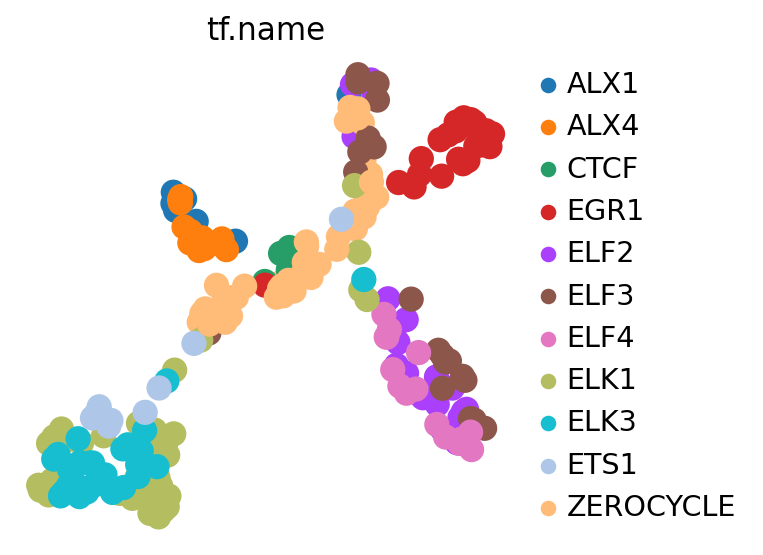

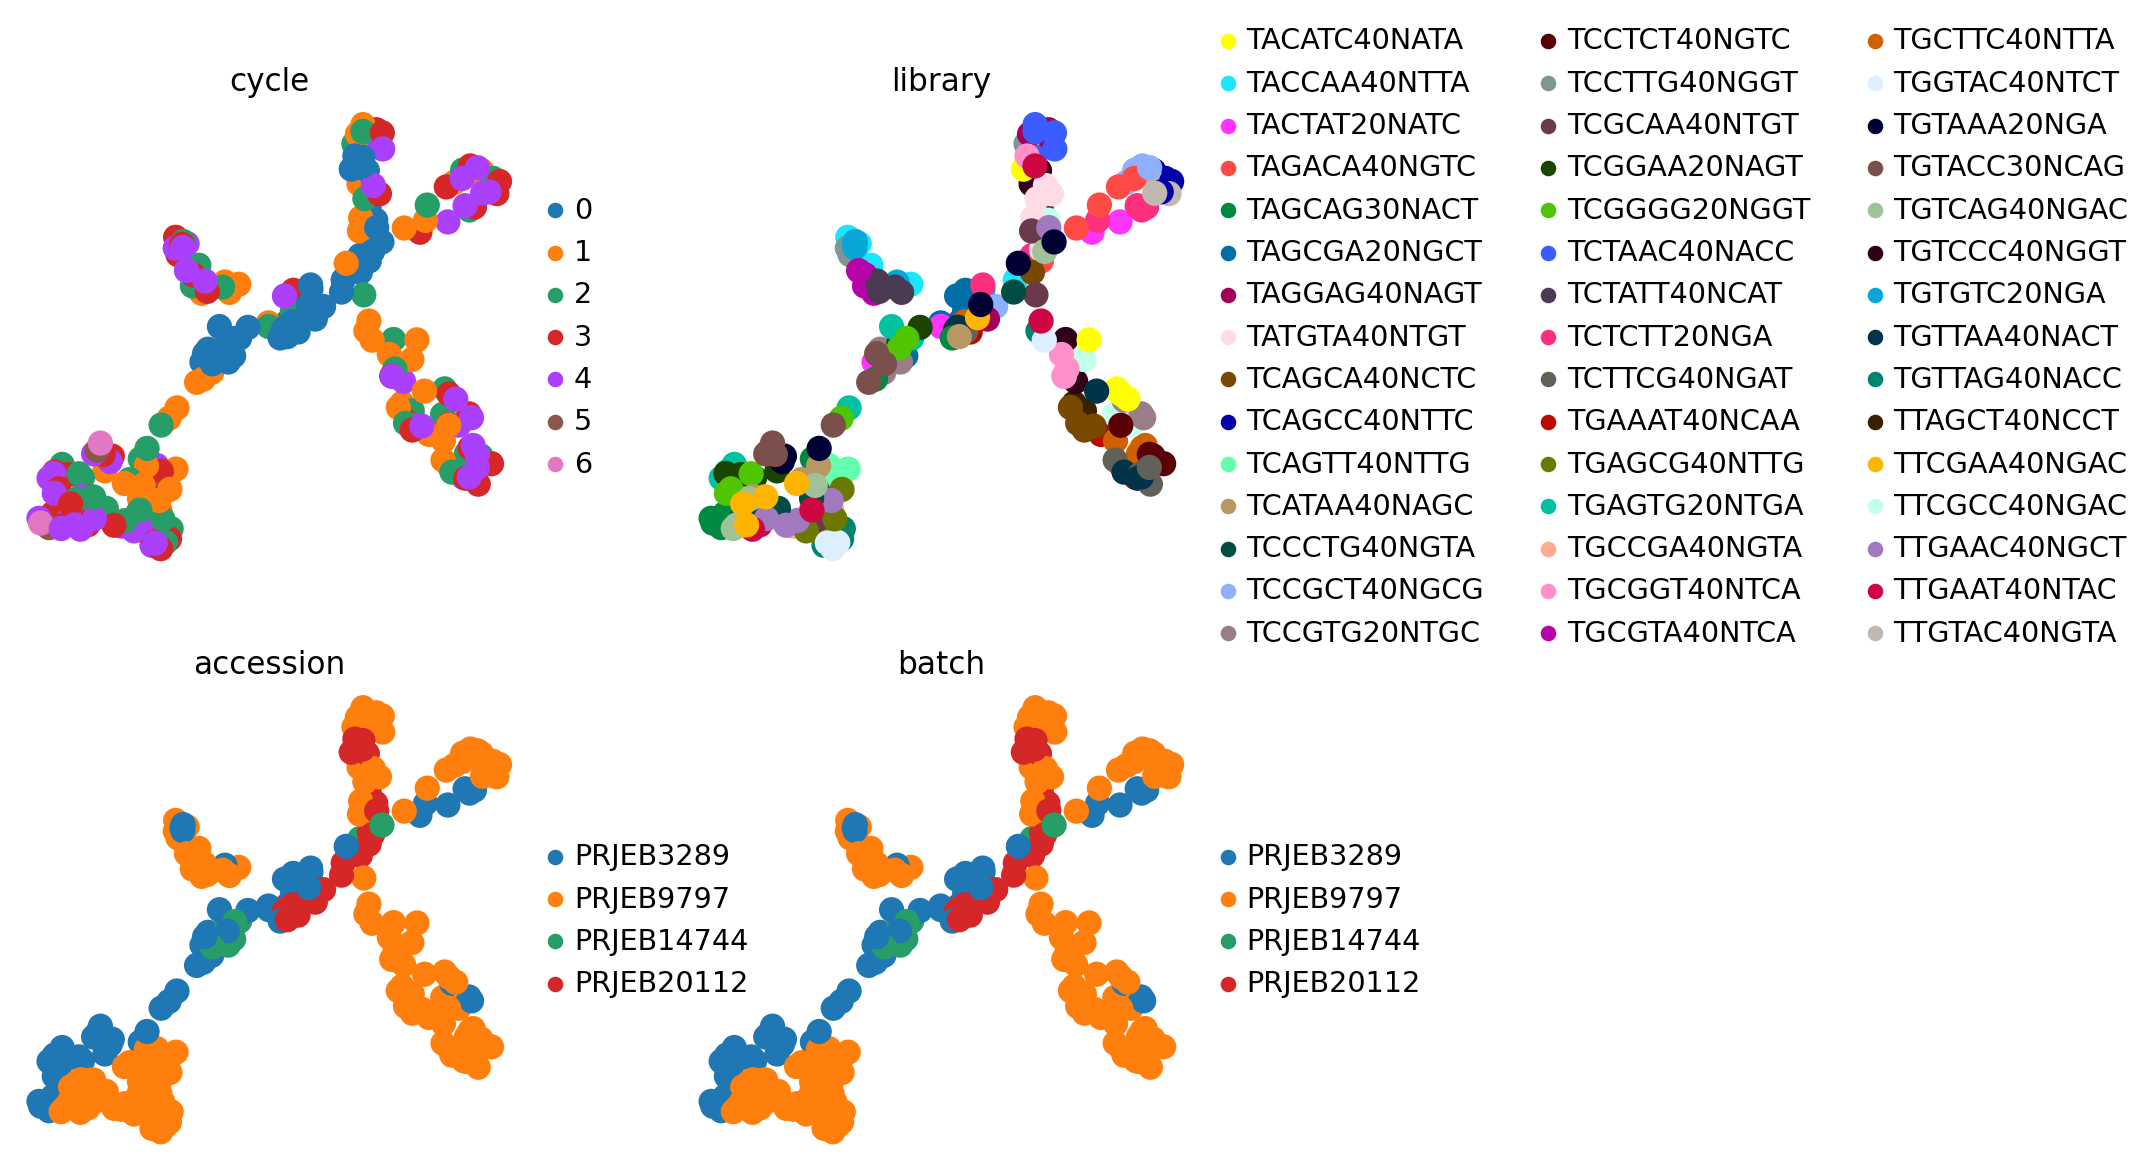

In [34]:
sc.pl.umap(
    adata,
    color=["tf.name"], 
    frameon=False,
)
sc.pl.umap(
    adata, 
    color=["cycle", "library", 'accession', 'batch'],
    ncols=2,
    frameon=False,
)

We see that while the cell types are generally well separated, nuisance variation plays a large part in the variation of the data.

### Visualization with batch correction (scVI)

Now, let us try using the scVI latent space to generate the same UMAP plots to see if scVI successfully accounts for batch effects in the data.

In [35]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

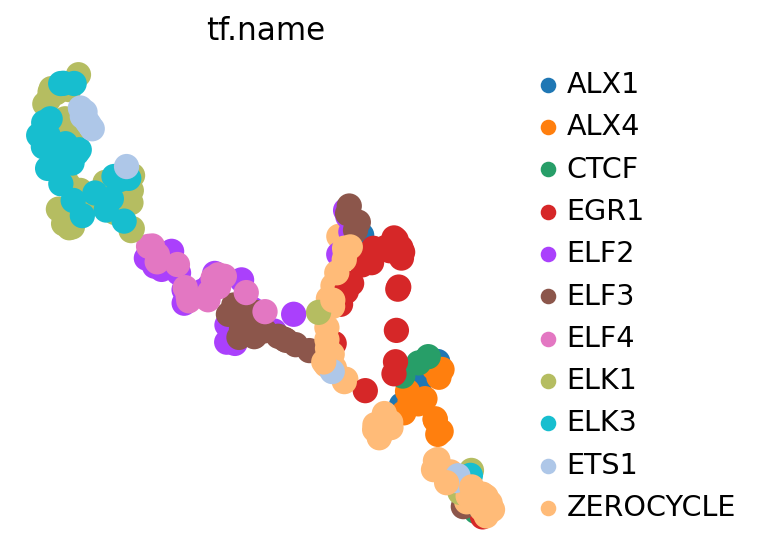

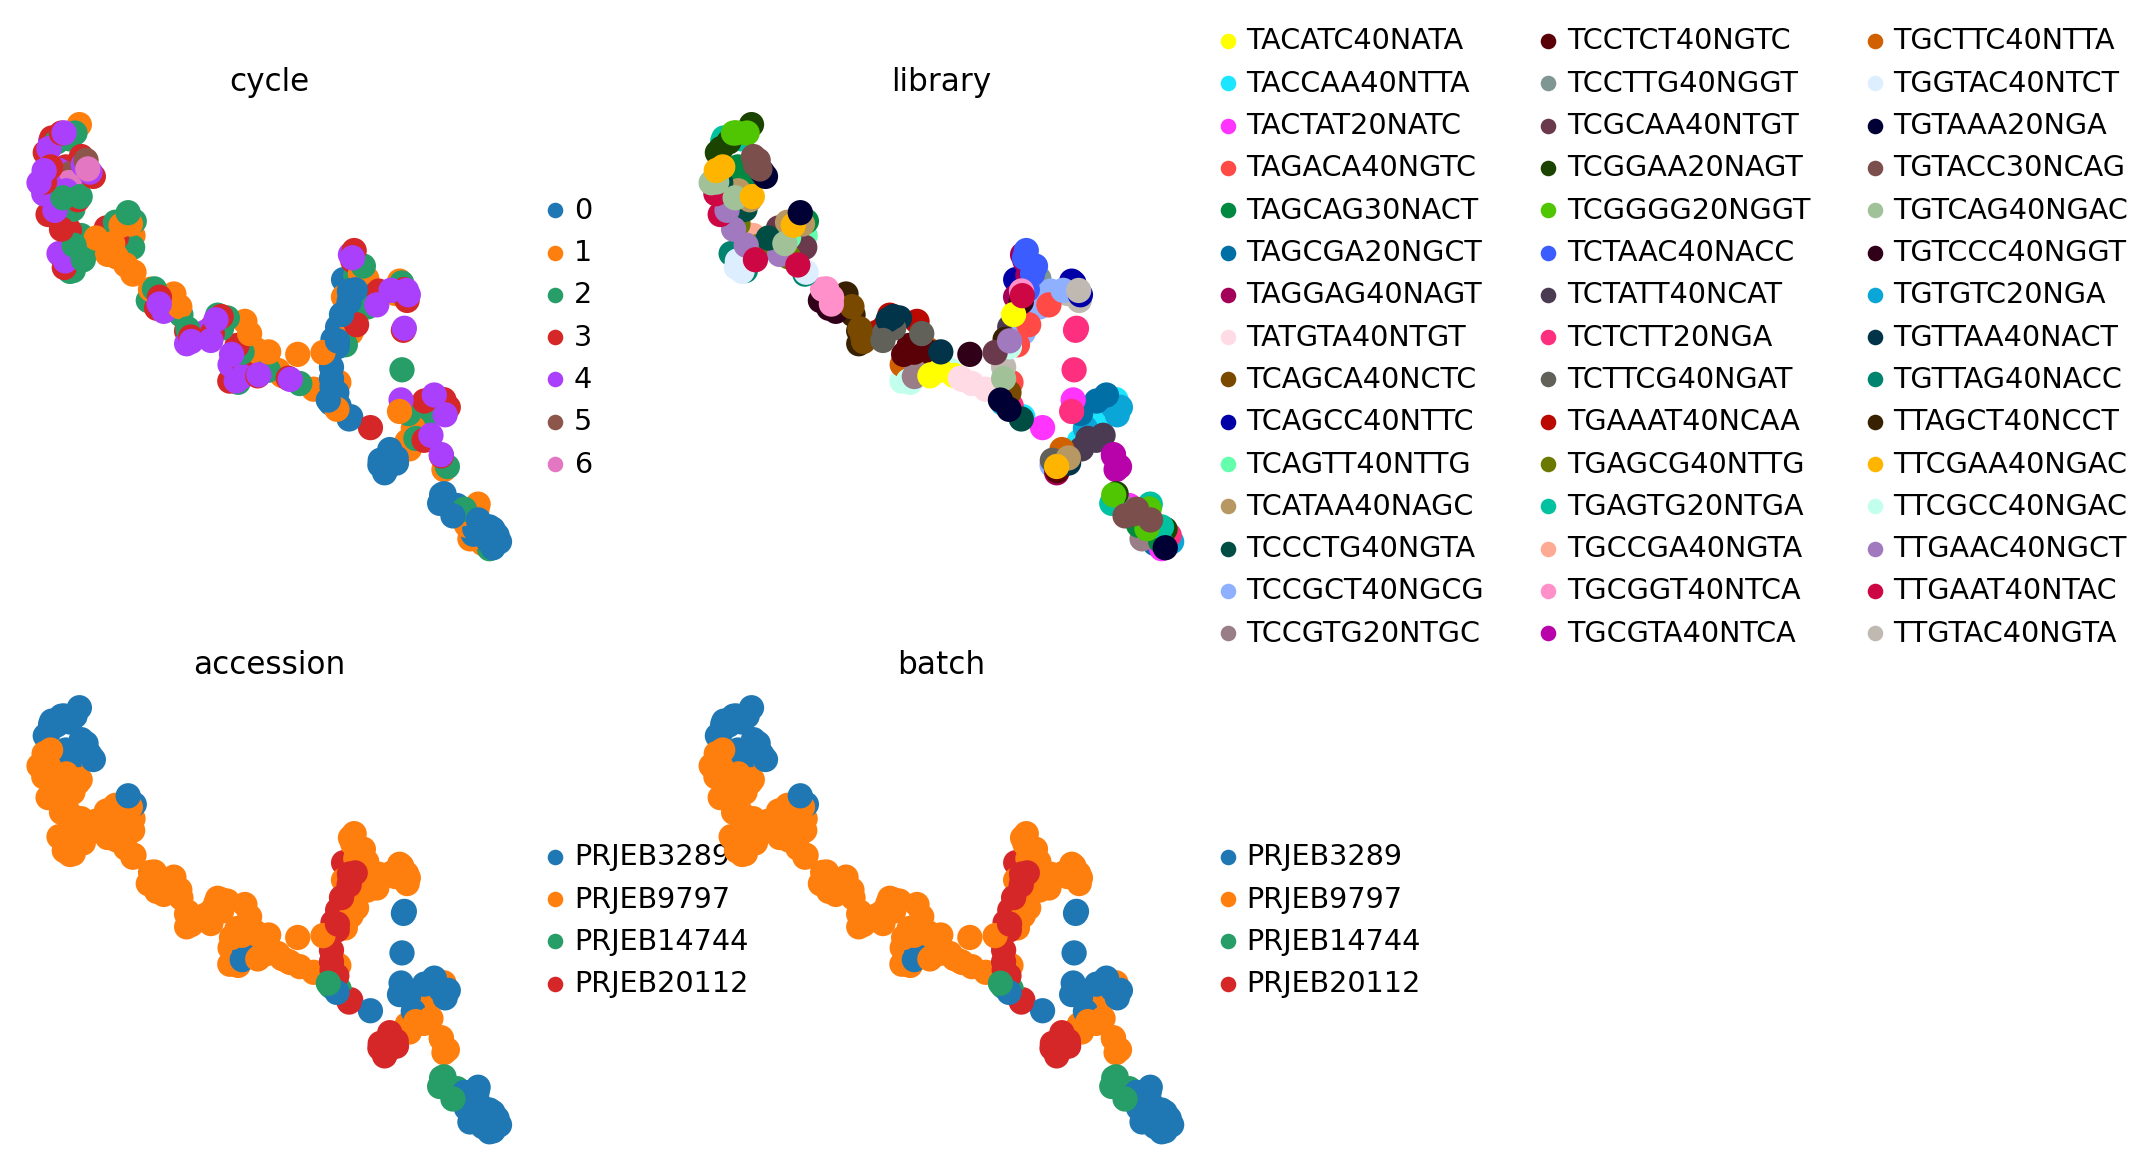

In [36]:
sc.pl.umap(
    adata, 
    color=["tf.name"], 
    frameon=False,
)
sc.pl.umap(
    adata, 
    color=["cycle", "library", 'accession', 'batch'],
    ncols=2,
    frameon=False,
)

In [44]:
# assert False

We can see that scVI was able to correct for nuisance variation due to nuclei/whole cell, age group, and donor, while maintaining separation of cell types.

### Clustering on the scVI latent space

The user will note that we imported curated labels from the original publication. Our interface with scanpy makes it easy to cluster the data with scanpy from scVI's latent space and then reinject them into scVI (e.g., for differential expression).

In [45]:
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)

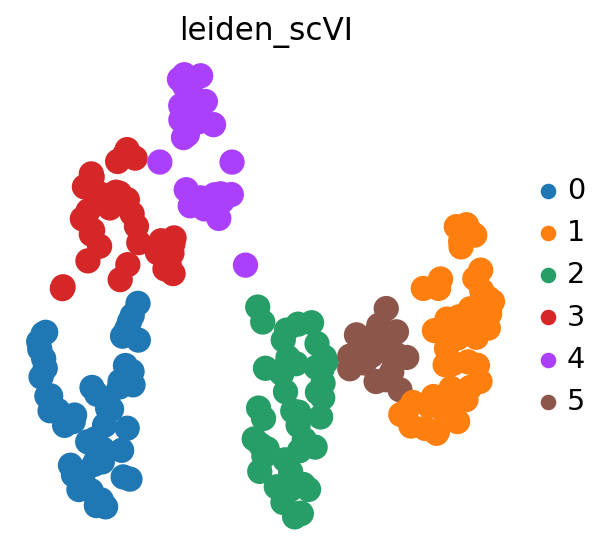

In [46]:
sc.pl.umap(
    adata, 
    color=["leiden_scVI"], 
    frameon=False,
)

## Use scib to calculate metrics

In [47]:
import scib

ModuleNotFoundError: No module named 'scib'